Link Kaggle : https://www.kaggle.com/code/sanjukinpinem/emotionclassifiersementara

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/raf-db-happy-sad-angry-neutral/train'
test_path = '/kaggle/input/raf-db-happy-sad-angry-neutral/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest'
)

images_size = 100
batch_size = 64

train_generator = train_datagen.flow_from_directory(
    train_path,                  
    target_size=(images_size, images_size), 
    batch_size=batch_size,          
    seed=32,                       
    shuffle=True,                    
    class_mode='categorical'       
)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.5
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    shuffle=False,
    class_mode='categorical')

Found 9978 images belonging to 4 classes.
Found 2505 images belonging to 4 classes.


In [3]:
# import numpy as np
# import matplotlib.pyplot as plt

# label_mapping = {0: "surprise", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "angry", 6: "neutral"}
# class_labels = list(train_generator.class_indices.keys())
# class_counts = {label_mapping[i]: 0 for i in range(len(label_mapping))}

# for i in range(len(train_generator)):
#     batch_data, batch_labels = train_generator[i]
#     for j in range(len(batch_data)):
#         class_idx = int(batch_labels[j].argmax())
#         class_label = label_mapping[class_idx]
#         class_counts[class_label] += 1

# class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# plt.figure(figsize=(10, 6))
# bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.title('Number of Images per Class')
# plt.xticks(rotation=45)

# legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=list(label_mapping.values())[i]) for i in range(len(label_mapping))]
# plt.legend(handles=legend_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

In [4]:
# label_mapping = {0: "surprise", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "angry", 6: "neutral"}
# class_labels = list(test_generator.class_indices.keys())
# class_counts = {label_mapping[i]: 0 for i in range(len(label_mapping))}

# for i in range(len(test_generator)):
#     batch_data, batch_labels = test_generator[i]
#     for j in range(len(batch_data)):
#         class_idx = int(batch_labels[j].argmax())
#         class_label = label_mapping[class_idx]
#         class_counts[class_label] += 1

# class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# plt.figure(figsize=(10, 6))
# bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.title('Number of Images per Class')
# plt.xticks(rotation=45)

# legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=list(label_mapping.values())[i]) for i in range(len(label_mapping))]
# plt.legend(handles=legend_labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()


In [5]:
# def Show_Images(target_gen):
#     batch_images, batch_labels = next(target_gen)
#     label_mapping = {0: "surprise", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "angry", 6: "neutral"}

#     plt.figure(figsize=(20, 20))
#     for n, i in enumerate(np.random.randint(0, len(batch_images), 16)):
#         plt.subplot(4, 4, n + 1)
#         plt.imshow(batch_images[i])
#         label_idx = np.argmax(batch_labels[i])  # Mengambil index label
#         plt.title(label_mapping[label_idx])  # Menggunakan label_mapping untuk nama kelas
#         plt.axis('off')
#     plt.show()

In [6]:
# Show_Images(train_generator)

In [7]:
# Show_Images(test_generator)

In [8]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',  
    patience=5,         
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

from tensorflow.keras import optimizers

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps=1000,            
    decay_rate=0.5,            
)

from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [9]:
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
def CustomCNN():
    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(images_size,images_size,3)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # model.add(Flatten()) 
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
        
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    return model
    # model.summary()

TL_Models = [
    CustomCNN(),
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    DenseNet121(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]

TL_Models_NAMES = [
    'CustomCNN',
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'DenseNet121',
]

for tl_model, model_name in zip(TL_Models, TL_Models_NAMES):
    if model_name == 'CustomCNN':
        pass
    else:
        tl_model.trainable = False

In [10]:
subset_images = []
subset_labels = []

desired_count = 200

for i in range(desired_count):
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    if len(subset_images) >= desired_count:
        break

X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [12]:
HISTORIES = []

for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
        # layers.Dense(2, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )
    
    history = model.fit(
        X_sub, y_sub,
        epochs=50,
        validation_split=0.2,
        batch_size=batch_size
    )
        
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50


2024-11-29 07:28:36.663711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 5s 491ms/step - loss: 13.9030 - accuracy: 0.2696 - val_loss: 1210.2196 - val_accuracy: 0.0769
Epoch 2/50
4/4 [==============================] - 0s 74ms/step - loss: 24.8681 - accuracy: 0.3235 - val_loss: 1006.3773 - val_accuracy: 0.0769
Epoch 3/50
4/4 [==============================] - 0s 75ms/step - loss: 26.3563 - accuracy: 0.3824 - val_loss: 735.6146 - val_accuracy: 0.0769
Epoch 4/50
4/4 [==============================] - 0s 78ms/step - loss: 21.2242 - accuracy: 0.3922 - val_loss: 135.1791 - val_accuracy: 0.3077
Epoch 5/50
4/4 [==============================] - 0s 73ms/step - loss: 14.6376 - accuracy: 0.4951 - val_loss: 99.5808 - val_accuracy: 0.3077
Epoch 6/50
4/4 [==============================] - 0s 74ms/step - loss: 9.4909 - accuracy: 0.4461 - val_loss: 26.4751 - val_accuracy: 0.3077
Epoch 7/50
4/4 [==============================] - 0s 75ms/step - loss: 6.2854 - accuracy: 0.5098 - val_loss: 35.6095 - val_accuracy: 0.3077
Epoch 8/50
4/4 [===

Training Tl Models:  17%|█▋        | 1/6 [00:19<01:37, 19.48s/it]

Epoch 1/50
4/4 [==============================] - 5s 750ms/step - loss: 2.9954 - accuracy: 0.4118 - val_loss: 5.6966 - val_accuracy: 0.4231
Epoch 2/50
4/4 [==============================] - 0s 41ms/step - loss: 2.5384 - accuracy: 0.5931 - val_loss: 4.7779 - val_accuracy: 0.4038
Epoch 3/50
4/4 [==============================] - 0s 43ms/step - loss: 2.2703 - accuracy: 0.6225 - val_loss: 4.8495 - val_accuracy: 0.4423
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 1.6000 - accuracy: 0.6863 - val_loss: 3.4916 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 0s 43ms/step - loss: 1.1724 - accuracy: 0.7255 - val_loss: 3.0375 - val_accuracy: 0.5385
Epoch 6/50
4/4 [==============================] - 0s 42ms/step - loss: 0.9213 - accuracy: 0.7598 - val_loss: 2.3574 - val_accuracy: 0.5769
Epoch 7/50
4/4 [==============================] - 0s 44ms/step - loss: 0.8367 - accuracy: 0.7353 - val_loss: 2.3564 - val_accuracy: 0.5385
Epoch 8/50
4/4 [==========

Training Tl Models:  33%|███▎      | 2/6 [00:33<01:04, 16.12s/it]

Epoch 1/50
4/4 [==============================] - 10s 859ms/step - loss: 2.8411 - accuracy: 0.4755 - val_loss: 3.2783 - val_accuracy: 0.3269
Epoch 2/50
4/4 [==============================] - 0s 93ms/step - loss: 2.0934 - accuracy: 0.5441 - val_loss: 3.1629 - val_accuracy: 0.4231
Epoch 3/50
4/4 [==============================] - 0s 91ms/step - loss: 1.6008 - accuracy: 0.6569 - val_loss: 3.6546 - val_accuracy: 0.3846
Epoch 4/50
4/4 [==============================] - 0s 99ms/step - loss: 2.0483 - accuracy: 0.5441 - val_loss: 3.3833 - val_accuracy: 0.4231
Epoch 5/50
4/4 [==============================] - 0s 92ms/step - loss: 1.7610 - accuracy: 0.6765 - val_loss: 2.9146 - val_accuracy: 0.5385
Epoch 6/50
4/4 [==============================] - 0s 91ms/step - loss: 1.4125 - accuracy: 0.7059 - val_loss: 3.7042 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 0s 92ms/step - loss: 1.4533 - accuracy: 0.7206 - val_loss: 3.7284 - val_accuracy: 0.4808
Epoch 8/50
4/4 [=========

Training Tl Models:  50%|█████     | 3/6 [01:02<01:05, 21.92s/it]

Epoch 1/50
4/4 [==============================] - 7s 849ms/step - loss: 2.9143 - accuracy: 0.2941 - val_loss: 3.9707 - val_accuracy: 0.4038
Epoch 2/50
4/4 [==============================] - 0s 38ms/step - loss: 2.8463 - accuracy: 0.5147 - val_loss: 3.3817 - val_accuracy: 0.4231
Epoch 3/50
4/4 [==============================] - 0s 37ms/step - loss: 1.8514 - accuracy: 0.5294 - val_loss: 3.3349 - val_accuracy: 0.4615
Epoch 4/50
4/4 [==============================] - 0s 36ms/step - loss: 1.4841 - accuracy: 0.6225 - val_loss: 2.8630 - val_accuracy: 0.4615
Epoch 5/50
4/4 [==============================] - 0s 37ms/step - loss: 1.1289 - accuracy: 0.6814 - val_loss: 2.3779 - val_accuracy: 0.4615
Epoch 6/50
4/4 [==============================] - 0s 37ms/step - loss: 0.7480 - accuracy: 0.7647 - val_loss: 1.7015 - val_accuracy: 0.3654
Epoch 7/50
4/4 [==============================] - 0s 37ms/step - loss: 0.7228 - accuracy: 0.7059 - val_loss: 1.6542 - val_accuracy: 0.4423
Epoch 8/50
4/4 [==========

Training Tl Models:  67%|██████▋   | 4/6 [01:17<00:38, 19.18s/it]

Epoch 1/50
4/4 [==============================] - 4s 477ms/step - loss: 1.8505 - accuracy: 0.3971 - val_loss: 2.7438 - val_accuracy: 0.3846
Epoch 2/50
4/4 [==============================] - 0s 45ms/step - loss: 1.4410 - accuracy: 0.5931 - val_loss: 2.3523 - val_accuracy: 0.4808
Epoch 3/50
4/4 [==============================] - 0s 43ms/step - loss: 1.4192 - accuracy: 0.5882 - val_loss: 1.8374 - val_accuracy: 0.5385
Epoch 4/50
4/4 [==============================] - 0s 43ms/step - loss: 1.0056 - accuracy: 0.6716 - val_loss: 1.9668 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 0s 43ms/step - loss: 0.9026 - accuracy: 0.6912 - val_loss: 1.4422 - val_accuracy: 0.6154
Epoch 6/50
4/4 [==============================] - 0s 42ms/step - loss: 0.6943 - accuracy: 0.7353 - val_loss: 1.5547 - val_accuracy: 0.4808
Epoch 7/50
4/4 [==============================] - 0s 42ms/step - loss: 0.6253 - accuracy: 0.7647 - val_loss: 1.3853 - val_accuracy: 0.5192
Epoch 8/50
4/4 [==========

Training Tl Models:  83%|████████▎ | 5/6 [01:29<00:16, 16.82s/it]

Epoch 1/50
4/4 [==============================] - 11s 2s/step - loss: 2.8394 - accuracy: 0.3284 - val_loss: 2.5679 - val_accuracy: 0.4231
Epoch 2/50
4/4 [==============================] - 0s 44ms/step - loss: 2.0519 - accuracy: 0.5196 - val_loss: 2.4193 - val_accuracy: 0.4231
Epoch 3/50
4/4 [==============================] - 0s 42ms/step - loss: 1.8340 - accuracy: 0.5637 - val_loss: 1.7232 - val_accuracy: 0.5769
Epoch 4/50
4/4 [==============================] - 0s 42ms/step - loss: 1.4402 - accuracy: 0.5833 - val_loss: 1.3878 - val_accuracy: 0.5769
Epoch 5/50
4/4 [==============================] - 0s 44ms/step - loss: 1.0653 - accuracy: 0.6373 - val_loss: 1.1215 - val_accuracy: 0.6154
Epoch 6/50
4/4 [==============================] - 0s 43ms/step - loss: 0.8883 - accuracy: 0.6912 - val_loss: 1.4616 - val_accuracy: 0.5577
Epoch 7/50
4/4 [==============================] - 0s 43ms/step - loss: 0.9161 - accuracy: 0.6520 - val_loss: 1.3740 - val_accuracy: 0.5577
Epoch 8/50
4/4 [============

Training Tl Models: 100%|██████████| 6/6 [01:49<00:00, 18.31s/it]


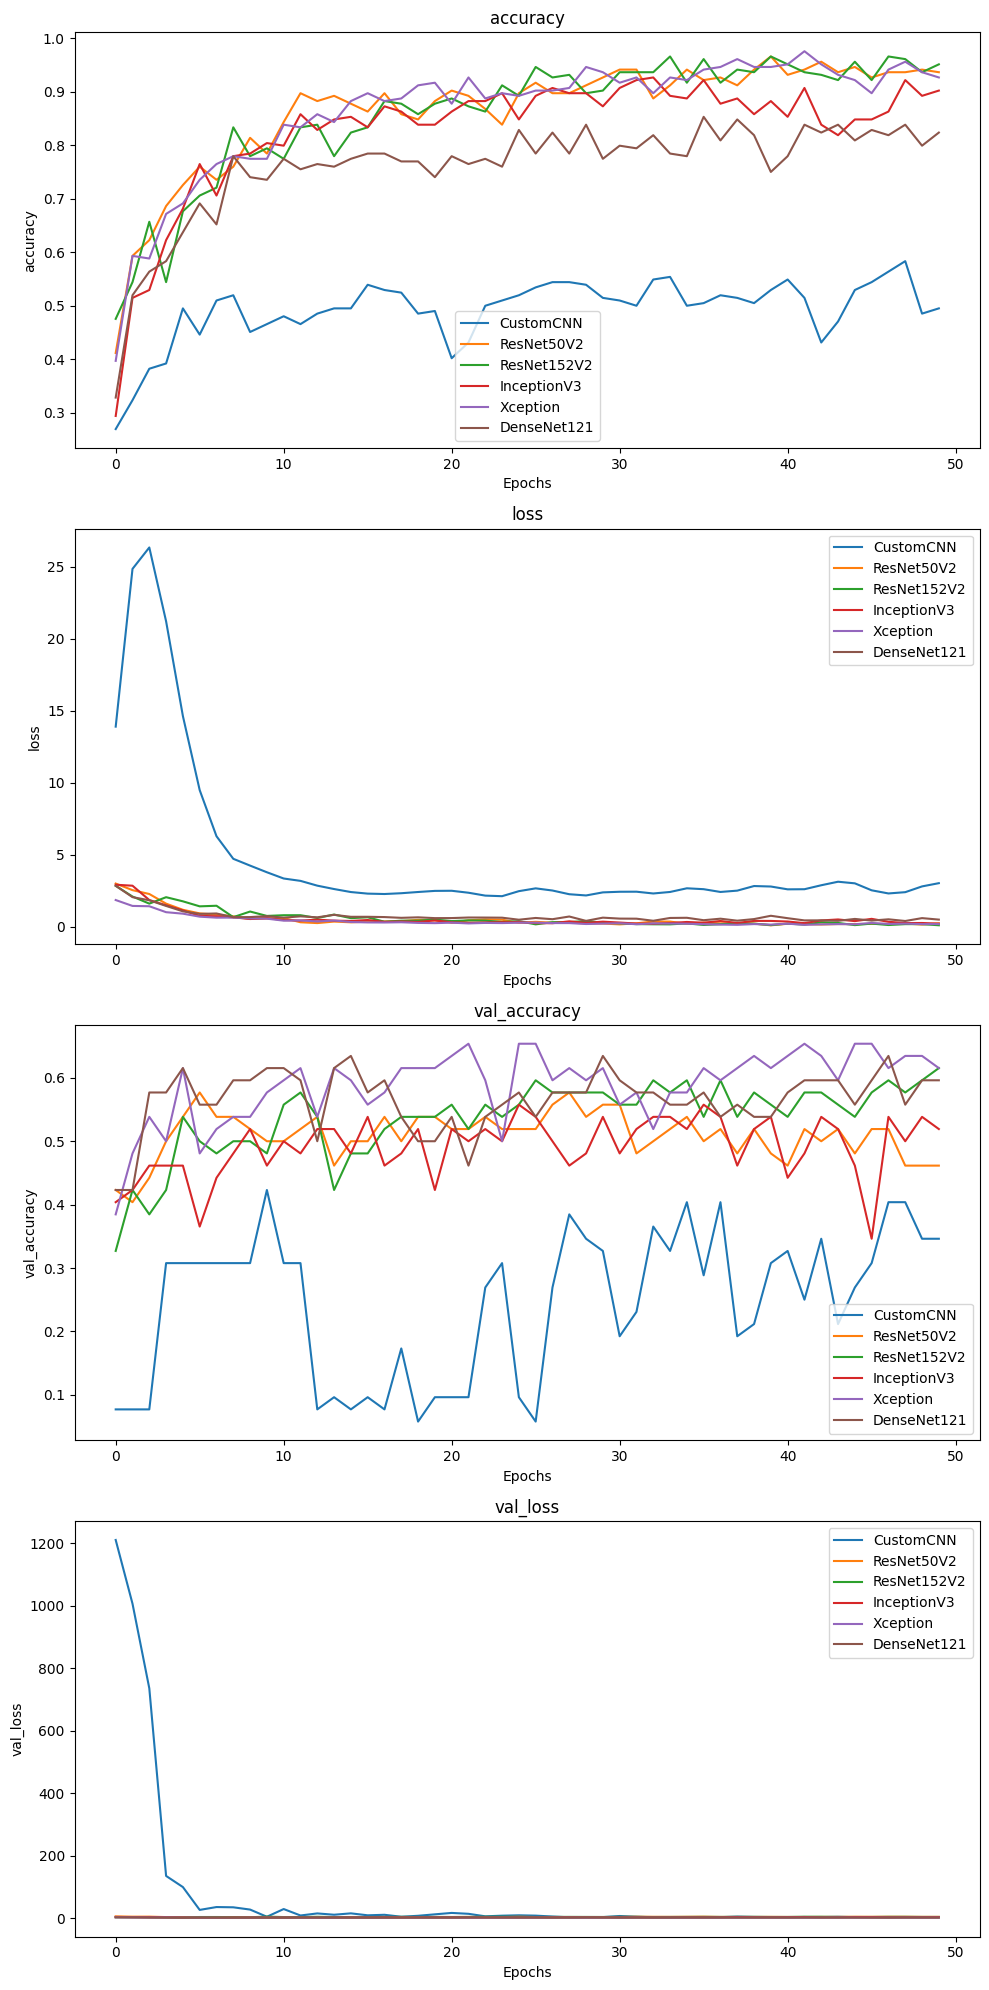

In [13]:
import matplotlib.pyplot as plt

metrics_to_plot = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 20))

for i, metric in enumerate(metrics_to_plot):
    for idx, history in enumerate(HISTORIES):
        axes[i].plot(history[metric], label=TL_Models_NAMES[idx])
    axes[i].set_title(f'{metric}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))
# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

In [ ]:
# model = tf.keras.models.Sequential([
#     base_model,
    
#     layers.Flatten(),
    
#     layers.Dense(256,activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(7,activation='softmax'),
#     # layers.Dense(2,activation='softmax'),
# ])

# optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)
# model.compile(optimizer=optimizer,
#              loss="categorical_crossentropy",
#               metrics=['accuracy']
#              )

# model.summary()

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // batch_size,
#     epochs=50,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // batch_size,
#     callbacks=[callback]
# )

In [ ]:
# # Evaluate on test dataset
# score = model.evaluate(test_generator, verbose=False)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

# # Accuracy
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# plt.title('Accuracy Graph')
# plt.legend()
# plt.figure()

# # Loss
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Loss Graph')
# plt.legend()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# label_mapping = {0: "surprise", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "angry", 6: "neutral"}

# y_true = test_generator.classes
# y_pred_probs = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
# y_pred = np.argmax(y_pred_probs, axis=1)

# cm = confusion_matrix(y_true, y_pred)
# labels = [label_mapping[i] for i in range(len(label_mapping))]

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Definisikan mapping label numerik ke nama kelas
# label_mapping = {0: "surprise", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "angry", 6: "neutral"}
# num_classes = len(label_mapping)

# # Variabel untuk menyimpan label sebenarnya dan prediksi
# true_labels = []
# predicted_labels = []
# x_data = []  # Untuk menyimpan semua gambar

# # Melakukan iterasi batch pada test_generator
# num_batches = len(test_generator)
# for i in range(num_batches):
#     x_batch, y_batch = test_generator[i]  # Mendapatkan batch data dan label
#     predictions = model.predict(x_batch)  # Prediksi dengan model

#     # Konversi dari one-hot encoding ke indeks kelas
#     true_labels.extend(np.argmax(y_batch, axis=1))
#     predicted_labels.extend(np.argmax(predictions, axis=1))
#     x_data.extend(x_batch)  # Menyimpan gambar

# # Ubah label numerik menjadi nama kelas
# true_class_labels = [label_mapping[i] for i in true_labels]
# predicted_class_labels = [label_mapping[i] for i in predicted_labels]

# # Pilih beberapa gambar untuk setiap label (misalnya, 3 gambar per kelas)
# samples_per_class = 3  # Atur jumlah gambar yang ingin diambil untuk setiap kelas
# selected_indices = []
# for label in range(num_classes):
#     indices = [i for i, t in enumerate(true_labels) if t == label]  # Cari semua indeks untuk label tertentu
#     selected_indices.extend(indices[:samples_per_class])  # Ambil hingga `samples_per_class` gambar per label

# # Plot gambar yang dipilih
# num_images = len(selected_indices)
# plt.figure(figsize=(15, (num_images // 5 + 1) * 3))  # Tinggi disesuaikan dengan jumlah baris
# for i, idx in enumerate(selected_indices):
#     img = x_data[idx]
#     if img.max() <= 1:  # Jika gambar dalam rentang [0, 1]
#         img = (img * 255).astype("uint8")  # Ubah ke rentang [0, 255]

#     plt.subplot((num_images // 5 + 1), 5, i + 1)
#     plt.imshow(img)
#     plt.title(f"True: {true_class_labels[idx]}\nPred: {predicted_class_labels[idx]}", fontsize=8)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [15]:
base_model = CustomCNN()
# Freeze the layers of the base modelCustom
# for layer in base_model.layers:
#     layer.trainable = False

modelCustom = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
        
    layers.Dense(512,activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def learning_rate_schedule(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    epoch_drop = 10
    return initial_lr * (drop_factor ** (epoch // epoch_drop))

lr_callback = LearningRateScheduler(learning_rate_schedule)

optimizer = Adam()

modelCustom.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = modelCustom.fit(train_generator,steps_per_epoch=train_generator.samples // batch_size,epochs=200,validation_data=test_generator,validation_steps=test_generator.samples // batch_size, callbacks=[lr_callback]  # Use the lr_callback here
)


Epoch 1/200


2024-11-29 07:31:02.686760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/sequential_10/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


155/155 [==============================] - 27s 133ms/step - loss: 7.0071 - accuracy: 0.5202 - val_loss: 4.6340 - val_accuracy: 0.5040 - lr: 0.0010
Epoch 2/200
155/155 [==============================] - 19s 119ms/step - loss: 2.8820 - accuracy: 0.6429 - val_loss: 2.3102 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 3/200
155/155 [==============================] - 18s 116ms/step - loss: 1.6316 - accuracy: 0.6822 - val_loss: 1.8444 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 4/200
155/155 [==============================] - 19s 124ms/step - loss: 1.2630 - accuracy: 0.7227 - val_loss: 1.4127 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 5/200
155/155 [==============================] - 18s 119ms/step - loss: 1.1550 - accuracy: 0.7451 - val_loss: 1.1708 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 6/200
155/155 [==============================] - 22s 141ms/step - loss: 1.1254 - accuracy: 0.7614 - val_loss: 1.1856 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 7/200
155/155 [==============================] - 23s

Test loss: 0.48870575428009033
Test accuracy: 0.8986027836799622


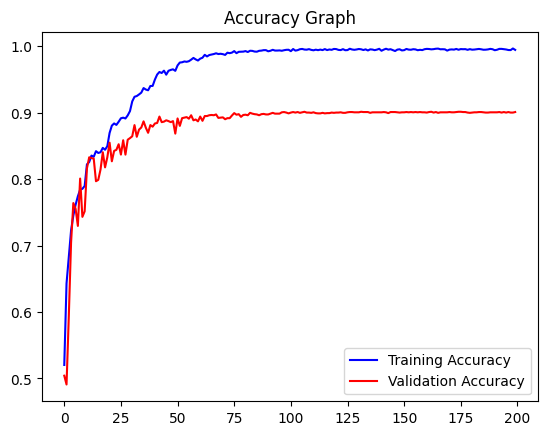

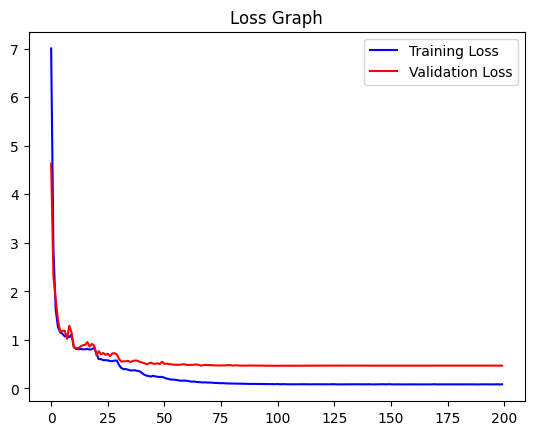

In [17]:
# Evaluate on test dataset
score = modelCustom.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

40/40 [==============================] - 7s 165ms/step


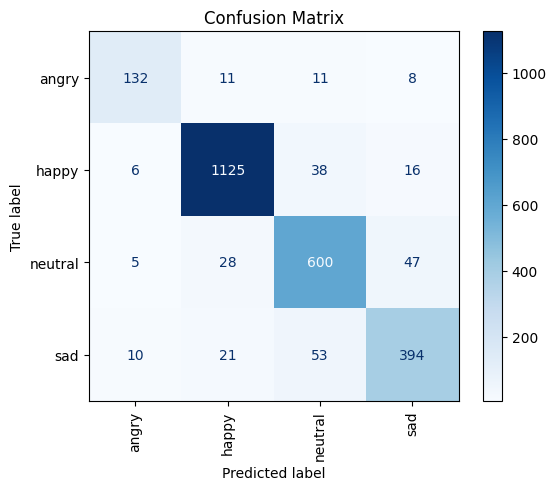

Test loss: 0.48870575428009033
Test accuracy: 0.8986027836799622


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_mapping = {0: "angry", 1: "happy", 2: "neutral", 3: "sad"}

y_true = test_generator.classes
y_pred_probs = modelCustom.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = [label_mapping[i] for i in range(len(label_mapping))]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

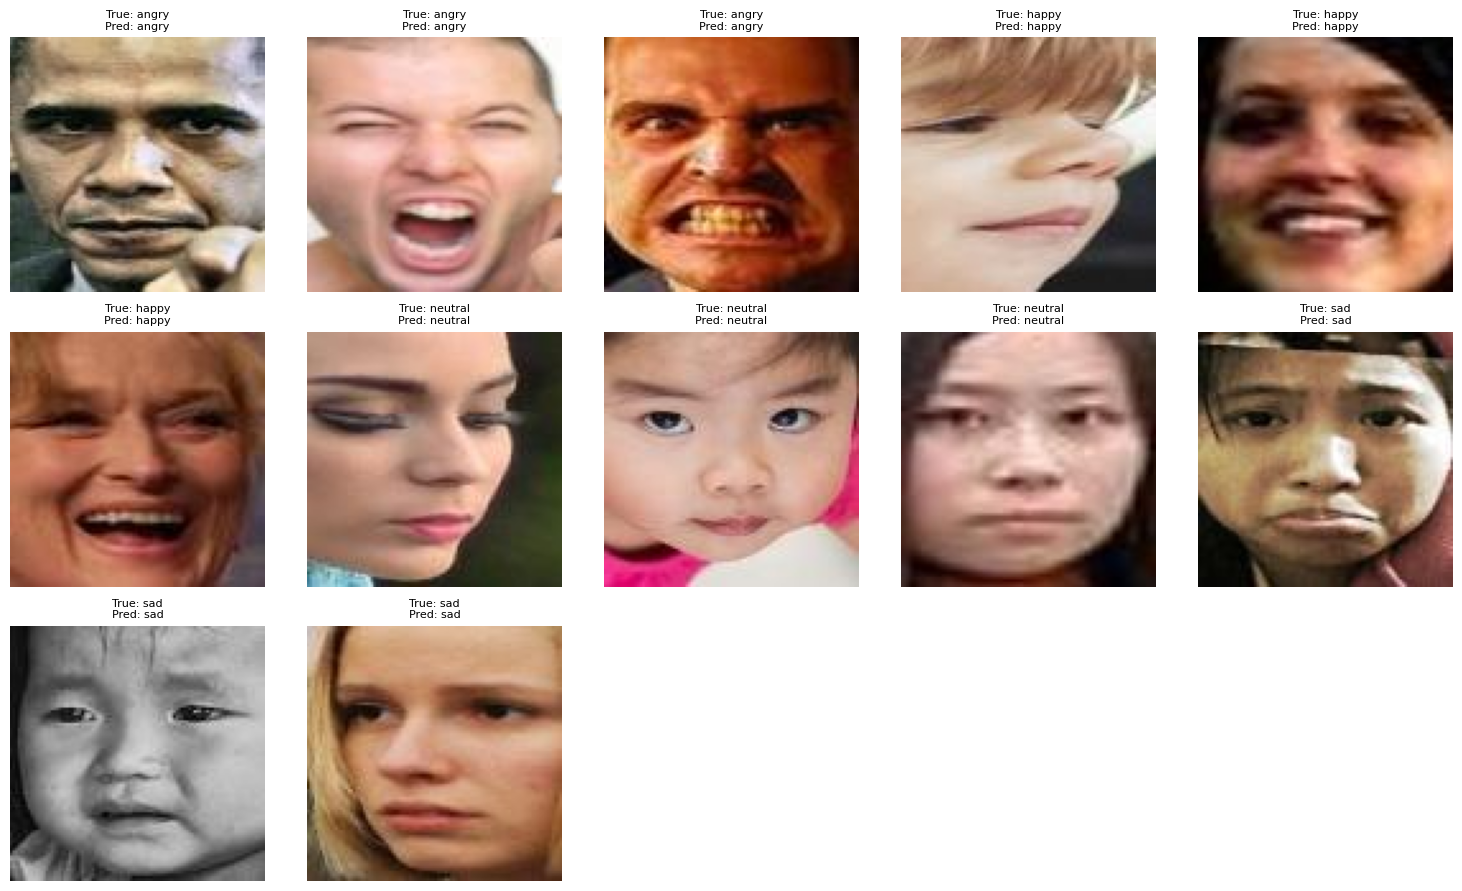

In [25]:
# Plot gambar yang dipilih
num_images = len(selected_indices)
columns = 5  # Atur jumlah kolom tetap
rows = (num_images + columns - 1) // columns  # Hitung jumlah baris

plt.figure(figsize=(columns * 3, rows * 3))  # Atur ukuran figure berdasarkan kolom dan baris
for i, idx in enumerate(selected_indices):
    img = x_data[idx]
    if img.max() <= 1:  # Jika gambar dalam rentang [0, 1]
        img = (img * 255).astype("uint8")  # Ubah ke rentang [0, 255]

    plt.subplot(rows, columns, i + 1)  # Gunakan jumlah baris dan kolom yang dihitung
    plt.imshow(img)
    plt.title(f"True: {true_class_labels[idx]}\nPred: {predicted_class_labels[idx]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [27]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)


OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [28]:
# Simpan model ke file HDF5
modelCustom.save("modelCustom4class.h5")

1/1 [==============================] - 0s 20ms/step
[[4.1741914e-01 7.8214319e-12 5.8257014e-01 1.0767987e-05]]
Predicted class: [2]
Predicted label: neutral


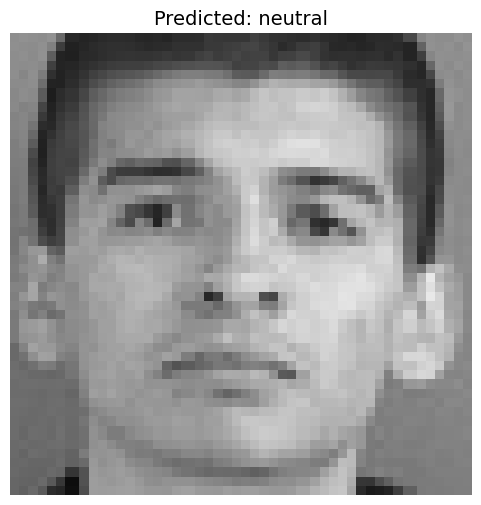

In [38]:
from tensorflow.keras.utils import load_img, img_to_array
# Path ke gambar single image
image_path = '/kaggle/input/fer2013/test/neutral/PrivateTest_1129340.jpg'

# Memuat gambar dengan ukuran sesuai yang digunakan saat pelatihan
image = load_img(image_path, target_size=(images_size, images_size))

# Mengubah gambar ke array NumPy
image_array = img_to_array(image) / 255.0  # Rescale seperti pada train_datagen

# Tambahkan dimensi batch (dari (100, 100, 3) menjadi (1, 100, 100, 3))
image_array = np.expand_dims(image_array, axis=0)

# Prediksi
predictions = modelCustom.predict(image_array)
print(predictions)

predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")

# Menampilkan label kelas (mapping class index ke nama kelas)
class_indices = train_generator.class_indices
labels = dict((v, k) for k, v in class_indices.items())  # Balik mapping dari index ke label
predicted_label = labels[predicted_class[0]]
print(f"Predicted label: {predicted_label}")

# Tampilkan gambar beserta label prediksi
plt.figure(figsize=(6, 6))
plt.imshow(image)  # Menampilkan gambar asli
plt.title(f"Predicted: {predicted_label}", fontsize=14)
plt.axis('off')  # Menghilangkan axis pada gambar
plt.show()